In [3]:
import pandas as pd
import numpy as np
import os
import warnings
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import math
import calendar
from matplotlib import pyplot as plt
%pylab inline
warnings.filterwarnings("ignore")
os.chdir(r'''D:\Coursera_ML\Final Project\Data''')

Populating the interactive namespace from numpy and matplotlib


#### 1. Загрузка данных.

In [4]:
data_january=pd.read_excel(r'''Grouped_data_january.xlsx''')
data_february=pd.read_excel(r'''Grouped_data_february.xlsx''')
data_march=pd.read_excel(r'''Grouped_data_march.xlsx''')
data_april=pd.read_excel(r'''Grouped_data_april.xlsx''')
data_may=pd.read_excel(r'''Grouped_data_may.xlsx''')

In [5]:
regions=(data_may.groupby('region').sum()['N_trips']/24/31)[data_may.groupby('region').sum()['N_trips']/24/31>=5].index.values

In [6]:
data_january=data_january[data_january.region.apply(lambda x: x in regions)]
data_february=data_february[data_february.region.apply(lambda x: x in regions)]
data_march=data_march[data_march.region.apply(lambda x: x in regions)]
data_april=data_april[data_april.region.apply(lambda x: x in regions)]
data_may=data_may[data_may.region.apply(lambda x: x in regions)]

In [5]:
data_train=pd.concat([data_january,data_february,data_march,data_april])
data_train.index=data_train.pickup_datehour

#### 2. Преобразование данных.

In [6]:
aggregated_data=pd.DataFrame(np.array([str(x)+'_'+str(y) for x in data_train.pickup_datehour.unique() for y in regions]).reshape(len(data_train.pickup_datehour.unique()),len(regions)),columns=regions,index=data_train.pickup_datehour.unique()).applymap(lambda x: x.split('_'))

In [7]:
def vlookup(x):
    try:
        val=data_train.loc[x[0],:][data_train.loc[x[0],:].region==int(x[1])]['N_trips'][0]
    except:
        val=0
    return val


In [8]:
aggregated=aggregated_data.applymap(vlookup)

In [9]:
aggregated_stand=aggregated.apply(lambda x: (x-np.mean(x))/np.std(x,ddof=1))

#### 3. Кластеризация данных.

In [10]:
from sklearn.cluster import KMeans

In [11]:
model=KMeans(n_clusters=7, random_state=0).fit(aggregated_stand.T)

In [ ]:
clusts,cl=aggregated_stand.apply(model.predict).T[0].values,aggregated_stand.apply(model.predict).T[0].unique()

Выберем 7 кластеров, кластеризация методом k-средних.

In [13]:
maps=pd.DataFrame(np.array([aggregated_stand.columns,clusts]).T)
dic={}
for val in maps[1].unique():
    dic[val]=maps[maps[1]==val][0].values

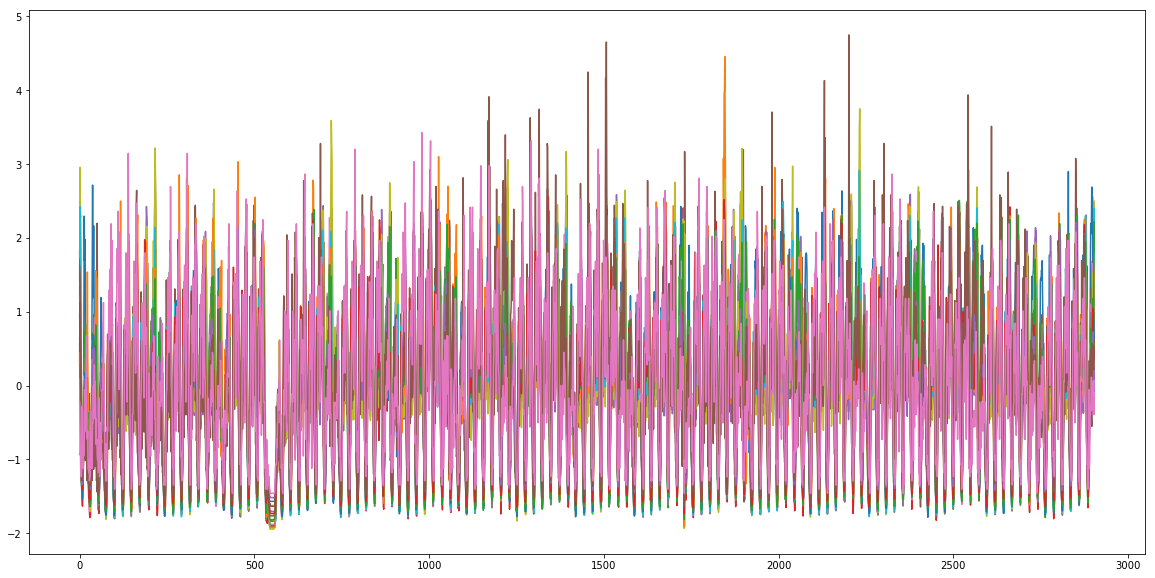

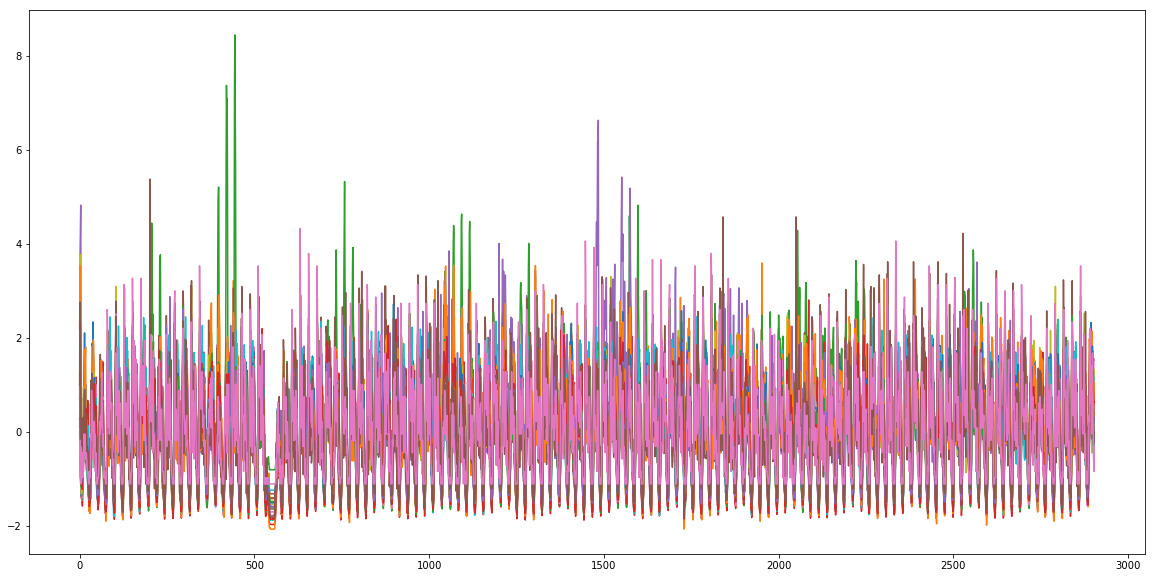

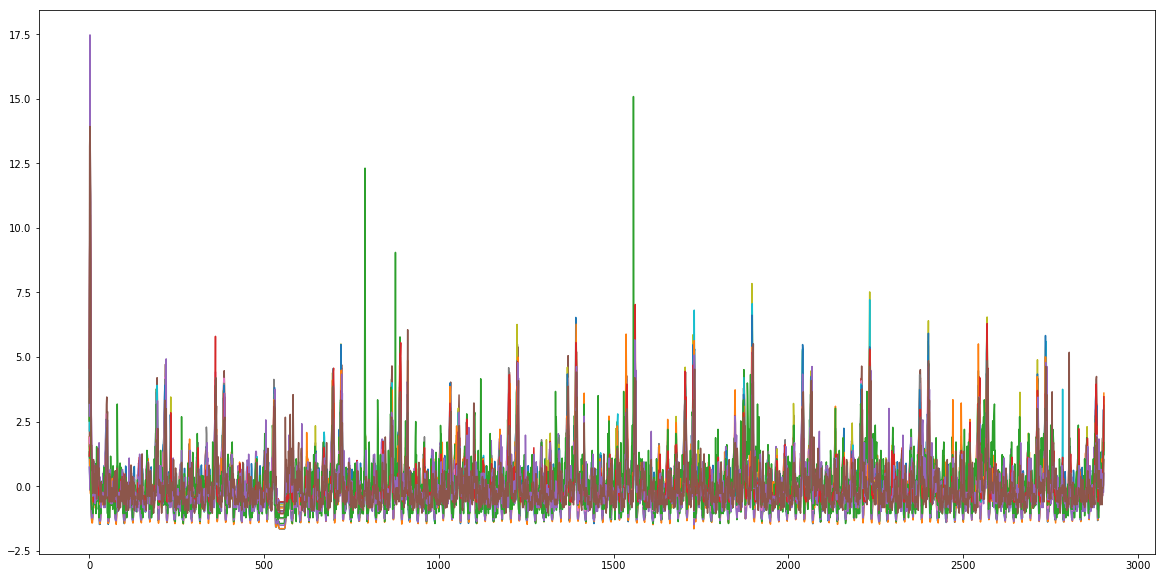

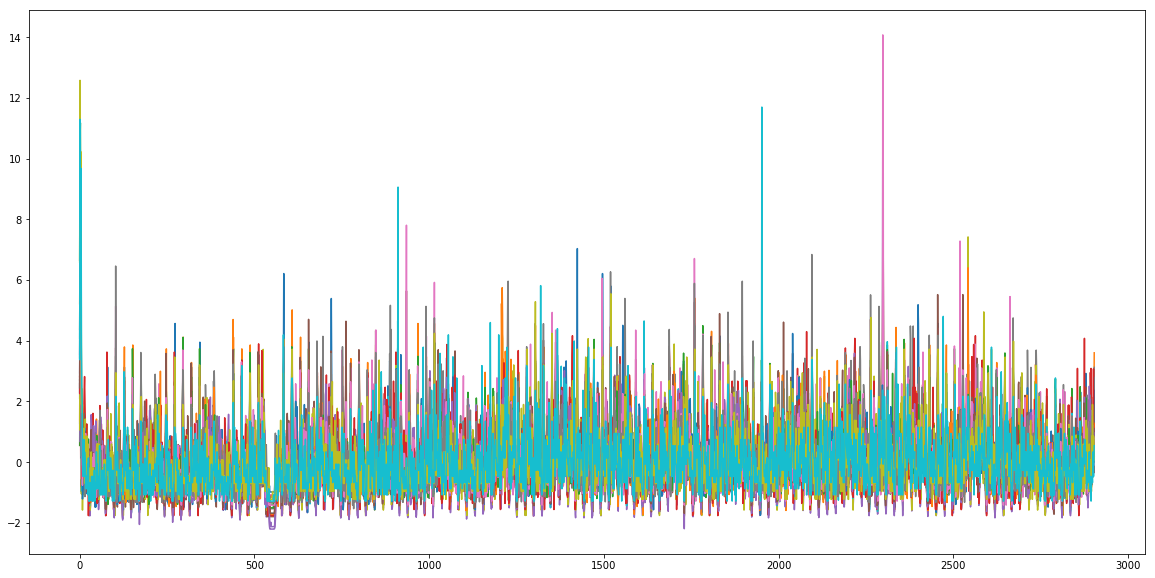

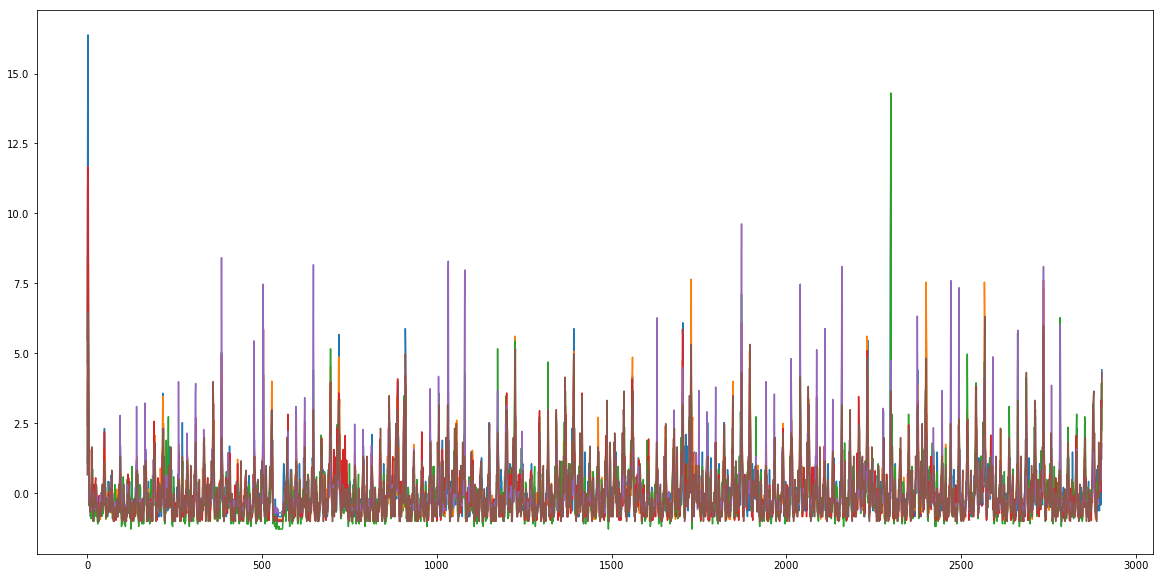

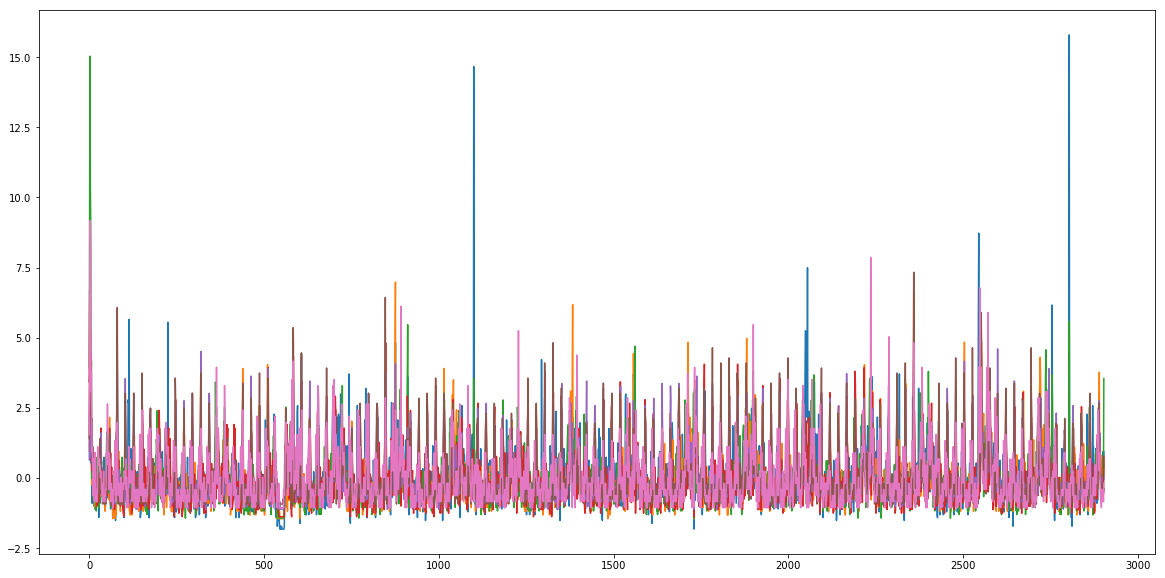

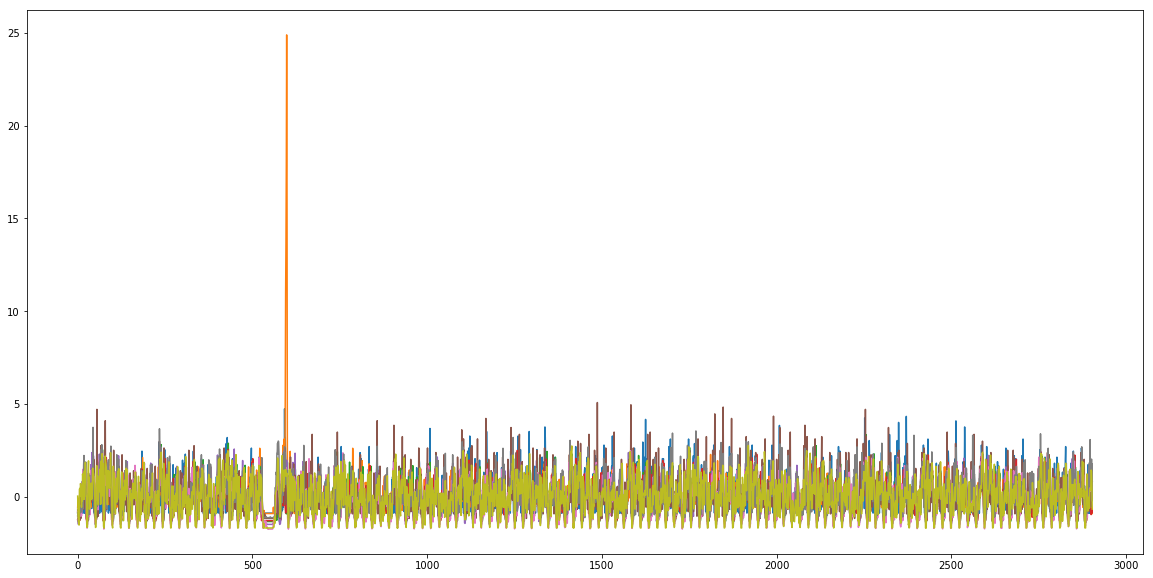

In [14]:
for val in dic:
    plt.figure(figsize=(20,10))
    plt.plot(aggregated_stand[dic[val]].values)
    plt.show()

Визуально ряды в рамках каждого кластера выглядят похоже (за исключением некоторых выбросов).

In [15]:
target_series=pd.DataFrame(model.cluster_centers_.T)

In [16]:
T=np.arange(1,len(target_series)+1)
exog=pd.DataFrame()

Нарисуем ряды, соответствующие центрам кластеров.

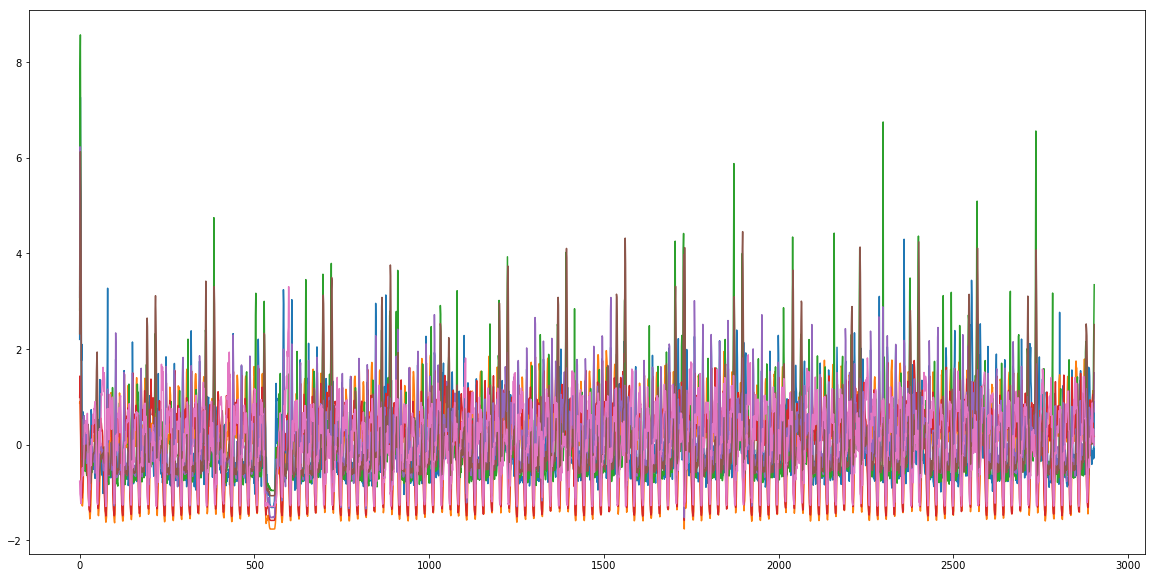

In [17]:
plt.figure(figsize=(20,10))
plt.plot(target_series.values)
plt.show()

Создадим матрицу эндогенных переменных.

In [18]:
K=5
for i in range(1,K+1):
    exog['sin_'+str(i)]=np.sin(T*2*math.pi*i/168)
    exog['cos_'+str(i)]=np.cos(T*2*math.pi*i/168)

In [19]:
exog['Intercept']=1
import statsmodels.api as sm

Протестируем целевые ряды на стационарность.

In [20]:
target_series.apply(lambda x: sm.tsa.stattools.adfuller(x)[1])

0    2.795784e-07
1    2.384713e-07
2    1.495535e-06
3    1.714888e-06
4    4.456681e-05
5    1.188363e-07
6    1.309578e-15
dtype: float64

Все ряды стационарны.

Обучим SARIMA для 7 целевых рядов. Так как обучение занимает много времени, возьмем "разумные" стартовые приближения для значений параметров: p=q=2, Q=P=1

In [21]:
from itertools import product
ps = range(0, 3)
d=0
qs = range(0, 3)
Ps = range(0, 2)
D=0
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [22]:
%%time
row={}
for i in target_series.columns:
    best_model=0
    # results = []
    best_aic = float("inf")

    for param in parameters_list:
        try:
            model=sm.tsa.statespace.SARIMAX(endog=target_series[i].values,exog=exog.values, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        except:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        # results.append([param, model.aic])
    row[i]=(best_model,best_param)
warnings.filterwarnings('default')


wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 1, 0, 0)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 1, 0, 0)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong pa

In [ ]:
with open('params.txt','w') as file:
    for i in row:
        file.wrie(str(i)+':'+str(row[i][1])+'\n')

В силу техничеких обстоятельств работы была прервана после подбора гиперпараметров, но мне удалось их сохранить. Ниже я загружаю их из записанного текстового файла.

In [21]:
with open('params.txt') as file:
    parameters=file.readlines()

In [22]:
parameters={int(x.split(':')[0]): eval(x.split(':')[1].rstrip()) for x in parameters}

In [23]:
clustdict={x:y for x,y in zip(aggregated_stand.columns,clusts)}

In [25]:
def get_models(x):
    cls=x.name
    pars=parameters[cls]
    res=sm.tsa.statespace.SARIMAX(endog=x.values,exog=exog.values
                                  , order=(pars[0], 0, pars[1]), 
                                            seasonal_order=(pars[2], 0, pars[3], 24)).fit(disp=-1)
    return res

In [26]:
models=target_series.apply(get_models)

Оценим модели SARIMA для каждого региона с гиперпараметрами кластера, используя данные до апреля включительно. Если оценка с данными гиперпараметрами в каком-то регионе невозможна, будем считать, что ряд удовлетворяет модели центра кластера.

In [36]:
def massive_SARIMA(x):
    try:
        cls=clustdict[x.name]
        pars=parameters[cls]
        res=sm.tsa.statespace.SARIMAX(endog=x.values,exog=exog.values
                                      , order=(pars[0], 0, pars[1]), 
                                                seasonal_order=(pars[2], 0, pars[3], 24)).fit(disp=-1)
    except:
        res=models[cls]
    return res

In [37]:
%%time
models_=aggregated_stand.apply(massive_SARIMA)

Wall time: 56min 25s


Оценим модели SARIMA для каждого региона с гиперпараметрами кластера, используя данные до мая включительно. Если оценка с данными гиперпараметрами в каком-то регионе невозможна, будем считать, что ряд удовлетворяет модели центра кластера.

In [7]:
data_may.index=data_may.pickup_datehour
aggregated_data_may=pd.DataFrame(np.array([str(x)+'_'+str(y) for x in data_may.pickup_datehour.unique() for y in regions]).reshape(len(data_may.pickup_datehour.unique()),len(regions)),columns=regions,index=data_may.pickup_datehour.unique()).applymap(lambda x: x.split('_'))

In [7]:
def vlookup(x):
    try:
        val=data_may.loc[x[0],:][data_may.loc[x[0],:].region==int(x[1])]['N_trips'][0]
    except:
        val=0
    return val
aggregated_may=aggregated_data_may.applymap(vlookup)

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
aggregated_stand_may=aggregated_may.apply(lambda x: (x-np.mean(x))/np.std(x,ddof=1))

In [32]:
T_may=np.arange(len(exog)+1,len(exog)+1+len(aggregated_stand_may))

In [33]:
exog_may=pd.DataFrame()
K=5
for i in range(1,K+1):
    exog_may['sin_'+str(i)]=np.sin(T_may*2*math.pi*i/168)
    exog_may['cos_'+str(i)]=np.cos(T_may*2*math.pi*i/168)

In [34]:
exog_may['Intercept']=1

In [38]:
aggregated_stand=pd.concat([aggregated_stand,aggregated_stand_may])
exog=pd.concat([exog,exog_may])

In [39]:
%%time
models_may=aggregated_stand.apply(massive_SARIMA)

Wall time: 32min 26s


Построим прогноз на май.

In [260]:
exog.index=np.arange(len(exog))
mays=len(exog_may)

In [284]:
def step6_forecast_AE(x):
    model=models_[x.name]
    predicts=model.predict(start=len(model.resid),end=len(model.resid)+len(x)-1,exog=exog_may)
    err=np.abs(x-predicts)
    sms=sum([sum(err[x:x+6]) for x in range(len(err)-6)])
    return sms

In [ ]:
error_array_may=aggregated_stand_may.apply(step6_forecast_AE)

In [271]:
q_may=sum(error_array_may)/len(regions)/739/6

Ошибка на СТАНДАРТИЗИРОВАННОМ ряде.

In [303]:
print('Средняя абсолютная ошибка прогноза в мае: {}'.format(q_may))

Средняя абсолютная ошибка прогноза в мае: 0.4573931728965153


Построим прогноз на июнь.

In [8]:
data_june=pd.read_excel(r'''Grouped_data_june.xlsx''')

In [9]:
data_june=data_june[data_june.region.apply(lambda x: x in regions)]

In [10]:
data_june.index=data_june.pickup_datehour

In [11]:
aggregated_data_june=pd.DataFrame(np.array([str(x)+'_'+str(y) for x in data_june.pickup_datehour.unique() for y in regions]).reshape(len(data_june.pickup_datehour.unique()),len(regions)),columns=regions,index=data_june.pickup_datehour.unique()).applymap(lambda x: x.split('_'))

In [13]:
def vlookup(x):
    try:
        val=data_june.loc[x[0],:][data_june.loc[x[0],:].region==int(x[1])]['N_trips'][0]
    except:
        val=0
    return val
aggregated_june=aggregated_data_june.applymap(vlookup)

In [14]:
aggregated_stand_june=aggregated_june.apply(lambda x: (x-np.mean(x))/np.std(x,ddof=1))

In [308]:
T_june=np.arange(len(exog)+1,len(exog)+1+len(aggregated_stand_june))

In [306]:
exog_june=pd.DataFrame()
K=5
for i in range(1,K+1):
    exog_june['sin_'+str(i)]=np.sin(T_june*2*math.pi*i/168)
    exog_june['cos_'+str(i)]=np.cos(T_june*2*math.pi*i/168)


In [323]:
exog_june['Intercept']=1

In [321]:
def step6_forecast_AE_june(x):
    model=models_may[x.name]
    predicts=model.predict(start=len(model.resid),end=len(model.resid)+len(x)-1,exog=exog_june)
    err=np.abs(x-predicts)
    sms=sum([sum(err[x:x+6]) for x in range(len(err)-6)])
    return sms

In [324]:
error_array_june=aggregated_stand_june.apply(step6_forecast_AE_june)

In [325]:
q_june=sum(error_array_june)/len(regions)/715/6

Ошибка на СТАНДАРТИЗИРОВАННОМ ряде.

In [461]:
print('Средняя абсолютная ошибка прогноза в июне: {}'.format(q_june))

Средняя абсолютная ошибка прогноза в июне: 0.4789217838562821


In [15]:
datehour_june=pd.Series(aggregated_data_june.index).apply(lambda x: x.split(' ')[0]+'_'+x.split(' ')[1].split(':')[0])

In [16]:
datehour_may=pd.Series(aggregated_data_may.index[-6:]).apply(lambda x: x.split(' ')[0]+'_'+x.split(' ')[1].split(':')[0])

In [17]:
datehour=pd.concat([datehour_may,datehour_june])
datehour.index=np.arange(len(datehour.index))

In [18]:
from datetime import datetime
datehour_ts=datehour.apply(lambda x: pd.to_datetime(x.split('_')[0]+' '+x.split('_')[1]+':00:00'))

In [517]:
check=list(datehour_ts[6:])
def checkdate(x):
    l=[]
    for i in range(1,7):
        if x+pd.DateOffset(hours=i) in check: l.append(i-1)
    return l    

In [581]:
n_preds=datehour_ts[5:-6].apply(checkdate)

In [587]:
n_preds.index=np.arange(len(n_preds))

In [588]:
indicies=pd.Series(np.arange(len(n_preds)))

In [590]:
mu_std=aggregated_june.apply(lambda x: (np.mean(x),np.std(x,ddof=1)))

In [591]:
def step6_forecast_june(x):
    model=models_may[x]
    predicts=mu_std[x][0]+mu_std[x][1]*model.predict(start=len(model.resid),end=len(model.resid)+len(aggregated_stand_june)-1,exog=exog_june)
    n_pred=n_preds
    def to_index(x):
        inds=np.array(n_pred[x])
        vals=predicts[x+inds]
        return list(vals)
    res=list(indicies.apply(to_index))
    return res

In [592]:
predicted_values=pd.Series(aggregated_stand_may.columns).apply(step6_forecast_june)

In [ ]:
reduced=predicted_values.apply(lambda x: reduce(lambda y,z: y+z,x))

In [ ]:
y=reduce(lambda x,z: x+z,reduced)

In [28]:
from itertools import product

In [25]:
binds=datehour_ts[5:-6].apply(lambda x: str(x).split(' ')[0]+'_'+str(int(str(x).split(' ')[1].split(':')[0]))).values 

In [37]:
ind_prod=product(aggregated_data_may.columns.values,binds, np.arange(1,7))                             

In [38]:
final_inds=[str(x1)+'_'+str(x2)+'_'+str(x3) for x1,x2,x3 in ind_prod]

In [41]:
with open('save.txt') as f:
    y=f.readlines()

In [42]:
y=[float(x) for x in y]

In [43]:
to_kaggle=pd.DataFrame([final_inds,y])

In [46]:
to_kaggle=to_kaggle.T

In [47]:
to_kaggle.columns=['id','y']

In [49]:
to_kaggle.to_csv('kaggle_4.csv',index=False)

# Ссылка на kaggle:
https://www.kaggle.com/c/yellowtaxi/submissions?sortBy=date&group=all&page=1&sortBy=date&group=all&page=1#